<a href="https://colab.research.google.com/github/Aaron3013352/customer-churn-prediction/blob/main/notebooks/01_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction

## Objective
Build an industry style churn prediction model with leakage safe preprocessing,
business aligned threshold selection, and unbiased test-set evaluation.


In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")

RANDOM_STATE = 42


In [19]:
DATA_PATH = "/content/sample_data/Telco_customer_churn.xlsx"
df = pd.read_excel(DATA_PATH)

df.head()


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [20]:
print("Shape:", df.shape)
df.info()


Shape: (7043, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Intern

## Data Overview
The dataset contains 7,043 customer records with a mix of demographic,
contractual, and service usage features. The target variable is customer churn.


In [21]:
leakage_cols = [
    "CustomerID",
    "Churn Reason",
    "Churn Score",
    "Churn Value",
    "Lat Long",
    "Latitude",
    "Longitude",
    "Zip Code",
    "City",
    "State",
    "Country",
]

df_model = df.drop(columns=leakage_cols)
print("df_model shape:", df_model.shape)
df_model.head()


df_model shape: (7043, 22)


,Count,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,CLTV
0,1,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,3239
1,1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2701
2,1,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,5372
3,1,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,5003
4,1,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,5340


## Feature Selection and Leakage Prevention
Customer identifiers, geographic fields, and churn-related outcome variables
were removed to prevent target leakage and ensure realistic model performance.


In [22]:
# How many blank strings?
print("Blank 'Total Charges':", (df_model["Total Charges"] == " ").sum())

df_model["Total Charges"] = df_model["Total Charges"].replace(" ", np.nan).astype(float)

print("NaNs in Total Charges:", df_model["Total Charges"].isna().sum())
df_model.info()


Blank 'Total Charges': 11
NaNs in Total Charges: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Count              7043 non-null   int64  
 1   Gender             7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure Months      7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7

/tmp/ipython-input-2786649339.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model["Total Charges"] = df_model["Total Charges"].replace(" ", np.nan).astype(float)


## Data Cleaning: Total Charges
The `Total Charges` feature contained hidden missing values represented as blank
strings. These were converted to NaN and cast to numeric, with missing values
handled later via imputation inside the modeling pipeline.


In [23]:
X = df_model.drop(columns=["Churn Label"])
y = df_model["Churn Label"]

print(X.shape, y.shape)
y.value_counts()


(7043, 21) (7043,)


,count
Churn Label,
No,5174
Yes,1869


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (4930, 21) Val: (1056, 21) Test: (1057, 21)


## Data Splitting Strategy
The data was split into training (70%), validation (15%), and test (15%) sets
using stratified sampling to preserve the churn rate. The validation set is
used exclusively for model and threshold selection.


In [25]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

print("Numeric:", list(num_features))
print("Categorical:", list(cat_features))


Numeric: ['Count', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']
Categorical: ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)


In [27]:
from sklearn.linear_model import LogisticRegression

baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])


In [28]:
baseline_model.fit(X_train, y_train)
baseline_model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Count', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(h...
                                                  Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [29]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

y_val_pred = baseline_model.predict(X_val)
y_val_proba = baseline_model.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score((y_val == "Yes").astype(int), y_val_proba))
print("PR-AUC:", average_precision_score(y_val, y_val_proba, pos_label="Yes"))


              precision    recall  f1-score   support

          No       0.92      0.71      0.80       776
         Yes       0.51      0.82      0.62       280

    accuracy                           0.74      1056
   macro avg       0.71      0.76      0.71      1056
weighted avg       0.81      0.74      0.75      1056

ROC-AUC: 0.8483937776141384
PR-AUC: 0.631454882845343


## Baseline Model Performance (Validation)
A logistic regression model was used as an interpretable baseline. Evaluation
focused on PR-AUC and recall due to class imbalance. Initial results showed
strong recall for churners at the cost of lower precision.


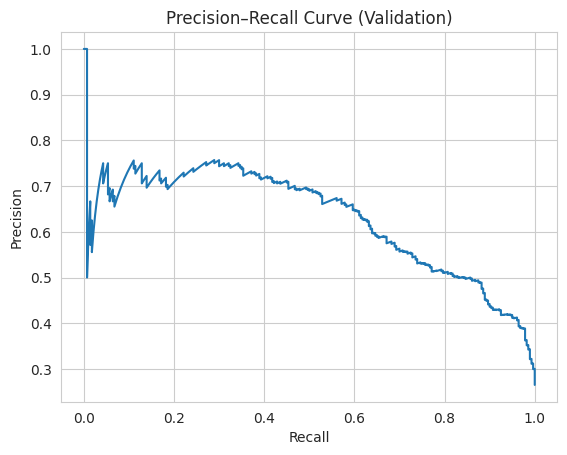

In [30]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve((y_val == "Yes").astype(int), y_val_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation)")
plt.show()


In [31]:
target_recall = 0.80
min_precision = 0.40

valid_idxs = np.where(
    (recall[:-1] >= target_recall) &
    (precision[:-1] >= min_precision)
)[0]

print("Num valid thresholds:", len(valid_idxs))

if len(valid_idxs) == 0:
    print("No thresholds meet both constraints. Try lowering min_precision (e.g., 0.35).")
else:
    best_idx = valid_idxs[-1]  # highest threshold that satisfies constraints
    custom_threshold = thresholds[best_idx]
    print("Chosen threshold:", custom_threshold)
    print("Precision at threshold:", precision[best_idx])
    print("Recall at threshold:", recall[best_idx])


Num valid thresholds: 238
Chosen threshold: 0.5218975636160174
Precision at threshold: 0.5114155251141552
Recall at threshold: 0.8


## Corrected Threshold Selection
A recall-only threshold resulted in excessive false positives due to an extremely
low probability cutoff. Introducing a minimum precision constraint produced a
more realistic operating point aligned with business trade offs.


In [32]:
if "custom_threshold" in globals():
    y_val_custom = (y_val_proba >= custom_threshold).astype(int)
    y_val_binary = (y_val == "Yes").astype(int)
    print(classification_report(y_val_binary, y_val_custom))


              precision    recall  f1-score   support

           0       0.91      0.72      0.81       776
           1       0.51      0.80      0.62       280

    accuracy                           0.74      1056
   macro avg       0.71      0.76      0.72      1056
weighted avg       0.80      0.74      0.76      1056



In [33]:
if "custom_threshold" in globals():
    y_test_proba = baseline_model.predict_proba(X_test)[:, 1]
    y_test_custom = (y_test_proba >= custom_threshold).astype(int)
    y_test_binary = (y_test == "Yes").astype(int)

    print("TEST SET RESULTS\n")
    print(classification_report(y_test_binary, y_test_custom))
    print("ROC-AUC:", roc_auc_score(y_test_binary, y_test_proba))
    print("PR-AUC:", average_precision_score(y_test_binary, y_test_proba))


TEST SET RESULTS

              precision    recall  f1-score   support

           0       0.90      0.76      0.83       776
           1       0.54      0.77      0.63       281

    accuracy                           0.76      1057
   macro avg       0.72      0.76      0.73      1057
weighted avg       0.80      0.76      0.77      1057

ROC-AUC: 0.8586785046043218
PR-AUC: 0.6875661054044604


## Final Test Set Evaluation
The final model and decision threshold were selected using validation data and
evaluated once on a held out test set. This provides an unbiased estimate of
real-world performance.

At the chosen operating point, the model maintains high recall for churners
while limiting unnecessary outreach, aligning with customer retention goals.


## Conclusion
This project demonstrates an end to end, leakage safe churn prediction workflow.
By aligning threshold selection with business objectives and evaluating performance
on a held out test set, the resulting model provides a realistic estimate of
production performance and actionable insights for retention strategies.
